# Mini-Project 3: Classification of Image Data 

**Authors**: Antoine Bonnet, Dragos Secrieru and Cyril Saidane 

**Course**: COMP 551: Applied Machine Learning, McGill University

In this project, we implement a multilayer perceptron from scratch and use it to classify image data from the benchmark Fashion-MNIST dataset. 

## Task 1: Acquire, preprocess, and analyze the data

In this section, we load and pre-process the Fashion-MNIST dataset for later use. 

### 1.0 Resource imports

We first import several Python libraries. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import sklearn
import plotly.graph_objects as go

You may need to run the following command in your terminal to gain access to the Fashion-MNIST dataset from TensorFlow:

`pip install tensorflow_datasets`



### 1.1 Loading and exploring the data

We first load the [Fashion-MNIST](https://www.kaggle.com/zalando-research/fashionmnist) from TensorFlow, and split it into training and testing sets. 


In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(Xtrain, Ytrain), (Xtest, Ytest) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


This dataset contains a training set of 60K instances and a test set of 10K instances, where each instance corresponds ot a 28x28 grayscale image labelled by one of 10 classes. 

In [ ]:
# Shape of dataset
print("Training features:", Xtrain.shape)
print("Training labels:", Ytrain.shape)
print("Testing features:", Xtest.shape)
print("Testing labels:", Ytest.shape)

Training features: (60000, 28, 28)
Training labels: (60000,)
Testing features: (10000, 28, 28)
Testing labels: (10000,)


The labels belong to 10 different classes, encoded as follows: 


0.   T-shirt / top
1.   Trouser
2.   Pullover
3.   Dress
4.   Coat
5.   Sandal
6.   Shirt
7.   Sneaker
8.   Bag
9.   Ankle boot

Each image is a $28 \times 28$ matrix, where each matrix entry is a pixel intensity value between $0$ and $255$. For better intuition, we show a few examples of images from the training set. 

Label:  9


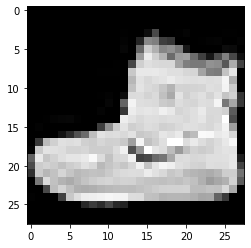

In [ ]:
print("Label: ", Ytrain[0])
plt.imshow(Xtrain[0], cmap="gray") 
plt.show() 

Label:  0


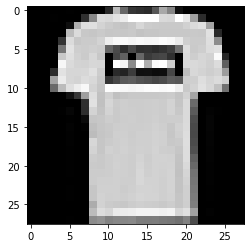

In [ ]:
print("Label: ", Ytrain[1])
plt.imshow(Xtrain[1], cmap="gray") 
plt.show() 

### 1.2 Preprocessing data

In this section, we prepare the downloaded data to be used by the multilayer perceptron. 

We first vectorize each $28 \times 28$ image into a vector of dimension $784 \times 1$. 

The dimensions of each data matrix is reshaped as: 

*   $X_{\text{train}}$: $60000 \times 28 \times 28 \to 60000 \times 784$
*   $X_{\text{test}}$: $10000 \times 28 \times 28 \to 10000 \times 784$

In [ ]:
# Reshape dataset to have a single channel
trainX = Xtrain.reshape((Xtrain.shape[0], Xtrain.shape[1] * Xtrain.shape[2]))
testX = Xtest.reshape((Xtest.shape[0], Xtest.shape[1] * Xtest.shape[2]))


In [ ]:
print(trainX.shape)
print(testX.shape)

(60000, 784)
(10000, 784)


We also normalize the intensity values of each image so that each image matrix entry has standard normal distribution over the whole training set.

In [ ]:
# Calculate training set average and standard deviation
trainXAvg = trainX.mean(axis=0)
trainXsd = trainX.std(axis=0)

# Normalize by setting mean 0 and std 1
trainData = (trainX - trainXAvg)/trainXsd
testData = (testX - trainXAvg)/trainXsd

We convert the labels to one-hot encoding, i.e. every label $y \in \{1, 2, \ldots, 10\}$ is converted to vector of size 10, with a single unit value at the index of the class associated with label $y$. 


In [ ]:
trainLabels = np.zeros((Ytrain.size, 10))
trainLabels[np.arange(Ytrain.size),Ytrain] = 1

testLabels = np.zeros((Ytest.size, 10))
testLabels[np.arange(Ytest.size),Ytest] = 1

### 1.3 Dataset Class

To make our life more enjoyable, we define a Dataset class which divides each dataset into its training and testing sets. 

In [ ]:
class Dataset:
    def __init__(self,trainData,trainLabels,testData,testLabels):
      self.trainData = trainData
      self.trainLabels = trainLabels
      self.testData = testData
      self.testLabels = testLabels
      return

# Instantiate fashionMNIST class
fashionMNIST = Dataset(trainData,trainLabels,testData,testLabels)

# Instantiate unnormalized fashionMNIST class
unnormFashionMNIST = Dataset(trainX, trainLabels, testX, testLabels)

## Task 2: Implement a Multilayer Perceptron

In this section, we implement a Multilayer Perceptron (MLP) from scratch to classify image data. Our implementation will include backpropagation and mini-batch gradient descent algorithm (SGD). 

**Model construction**

Our MLP will consist of 3 types of layers: 

1.   **Input layer**: Vector $x$ of length $D = 784$ representing a vectorized image. 
2.   **Hidden layers**: We have $K$ hidden layers, where each $k$-th hidden layer corresponds to a vector $z^{(k)}$ of length $M_k$. 
3.   **Output layer**: Vector $\hat{y}$ of length $C=10$, where each entry $\hat{y}_c$ is the estimated probability that the instance $x$ belongs to class $c$. 

**Weights, biases and activation functions**

The weights between every pair of adjacent hidden layers $z^{(k-1)} \in \mathbb{R}^{M_{k-1}}$ and $z^{(k)}\in \mathbb{R}^{M_{k}}$ (including the input layer $x \equiv z^{(0)}$ and the output layer $\hat{y} \equiv z^{(K+1)}$) are given by the matrix $W^{(k)} \in \mathbb{R}^{M_{k} \times M_{k-1}}$, where each entry $W_{i,j}^{(k)}$ is the weight of the connection from node $z_{j}^{(k)}$ to node $z_{i}^{(k+1)}$. 






### 2.1 Activation functions

Every layer in the network is computed from a chosen activation function. We will explore various activation functions for the hidden layers; the `logistic`, `softmax`, `ReLu`, `leakyReLu` and `tanh` activation functions. 



*   `logistic`: $h(x) = \sigma(x) = \frac{1}{1+e^{-x}}$
*   `softmax`: $h(x)_c = \frac{e^{x_c}}{\sum_{c'} e^{x_c'}}$
*    `ReLu`: $h(x) = max(x, 0)$
*   `leakyReLu`: $h(x, \gamma) = max(x, 0) + \gamma \cdot min(x,0)$
*   `tanh`: $h(x) = 2 \sigma(x) - 1$




In [ ]:
logistic = lambda z: np.reciprocal(1 + np.exp(-z))
softmax = lambda z: np.exp(z)/np.sum(np.exp(z))
ReLu = lambda z: np.maximum(z,0)
leakyReLu = lambda z, gamma: np.maximum(z,0) + gamma*np.minimum(z,0)
tanh = lambda z: 2*logistic(z) - 1

We also add the corresponding derivatives of each activation function. 
*   `logisticD`: $h'(x) = \sigma(x) \cdot (1-\sigma(x))$
*   `softmaxD`: $h(x)_c = \text{softmax}(x) \cdot (1-\text{softmax}(c))$
*   `ReLuD`: $h'(x) = \begin{cases} 1 & x \geq 0 \\ 0 & x < 0\end{cases}$
*   `leakyReLuD`: $h'(x, \gamma) = \begin{cases} 1 & x \geq 0 \\ \gamma & x < 0\end{cases}$
*   `tanhD`: $h(x) = 1 - \tanh(x)^2$


In [ ]:
logisticD = lambda z: np.multiply(logistic(z), (1-logistic(z)))
softmaxD = lambda z: np.multiply(softmax(z), (1-softmax(z)))
ReLuD = lambda z: (z>0).astype(int)
leakyReLuD = lambda z, gamma: (z>0).astype(int) + gamma*(z<0).astype(int)
tanhD = lambda z: 1 - np.square(tanh(z))

We also define an activation function class, comprising both the actual activation function and its derivative, for later ease of use. 

In [ ]:
class activation: 
  def __init__(self,function,derivative, params=None):
    if (params == None):
      self.function = function
      self.derivative = derivative
    else: # For leaky ReLu we might have gammas
      self.function = lambda z: function(z, params)
      self.derivative = lambda z: derivative(z, params)

logisticAc = activation(logistic, logisticD)
softmaxAc= activation(softmax, softmaxD)
ReLuAc = activation(ReLu, ReLuD)
tanhAc = activation(tanh, tanhD)
leakyReLuAc = activation(leakyReLu, leakyReLuD, 0.1)

### 2.2 Forward Propagation

Let's say every hidden layer $k$ has an activation function denoted by $h^{(k)}$. Given an input layer $z^{(k-1)}$, we can obtain the next layer's value $z^{(k)}$ by recursively applying the feed-forward rule for every layer $k$:

$$z^{(k)} = h^{(k)} (u^{(k)}) = h^{(k)} \big( W^{(k)} \cdot z^{(k-1)} + b^{(k)}\big)$$

Given an input $x^{(n)}$, we can obtain the network's prediction $\hat{y}^{(n)}$ by propagating forward over every layer $k$ until we reach the output layer. As we are concerned with image classification, the output layer $\hat{y}$ is obtained from the last hidden layer $z^{(K)}$ using the softmax activation function: 
$$ \hat{y} = \text{softmax}(u^{(K+1)}) = \text{softmax}(W^{(K+1)} z^{(K)} + b^{(K+1)}) $$
$$ \hat{y}_c = \frac{e^{z^{(K)}_c}}{\sum_{c'=1}^{C} e^{z^{(K)}_{c'}}} \; \forall 1 \leq c \leq C.$$

$$\frac{\partial}{\partial u_c} \hat{y}_k = \begin{cases} \hat{y}_k (1-\hat{y}_k) & k = c \\ - \hat{y}_c \hat{y}_k & k \neq c\end{cases} $$

In particular, the predicted class of the input $x$ corresponds to
$$ \hat{c} = \text{argmax}_c \; \hat{y}_c.$$

We use the above feed-forward rule to propagate the layer values from input $x$ to output $\hat{y}$ in the network.









In [ ]:
# FEED-FORWARD: Compute layer values
def feed_forward(x, activations, weights, biases, depth):
  Z = []  # List of layer values (with activation)
  U = []  # List of layer values (without activation)
  Zk = x
  for k in range(depth+1):  # Compute all hidden layers Z{1}, ..., Z{K+1}, yh
    act = activations[k]   # h{k}
    Wk = weights[k]        # W{k}
    Bk = biases[k]         # b{k} 
    Uk = np.dot(Wk, Zk) + Bk # u{k} = W{k} * z{k-1} + b{k}
    Zk = act.function(Uk) # z{k} = h{k}(u{k})
    Z.append(Zk)
    U.append(Uk)
  return U, Z



### 2.3 Backpropagation

At the output layer is computed the cost function, which is the average loss of the sample

$$J(y, \hat{y}) = \frac{1}{n} \sum_n L(y^{(n)}, \hat{y}^{(n)}) $$

We want to update the weight parameters $W^{(1)}, \ldots, W^{(K+1)} $ and bias parameters $B^{(1)}, \ldots, B^{(K+1)} $ using gradient descent by computing the partial derivatives 

$$ \frac{\partial J}{\partial W^{(1)}}, \ldots, \frac{\partial J}{\partial W^{(K+1)}} \quad \text{and} \quad \frac{\partial J}{\partial B^{(1)}}, \ldots, \frac{\partial J}{\partial B^{(K+1)}}$$

For any $1 \leq k \leq K+1$,

$$ \frac{\partial J}{\partial W^{(k)}} = \frac{1}{n} \sum_n \frac{\partial }{\partial W^{(K)}} L(y^{(n)},\hat{y}^{(n)}) $$

$$ \frac{\partial J}{\partial B^{(k)}} = \frac{1}{n} \sum_n \frac{\partial }{\partial B^{(K)}} L(y^{(n)},\hat{y}^{(n)}) $$

The loss function used for multi-class classification is the softmax-cross-entropy cost function

$$L(y, \hat{y}) = \sum_c y_c \log \hat{y}_c$$

Using backpropagation, we can start from the output layer $\hat{y} = z^{(K+1)}$ by initializing 

$$\frac{\partial L}{\partial z^{(K+1)}} = \hat{y} - y$$

as given above and then computing the partial derivatives by solving the following rules recursively ($\odot$ denotes coordinate-wise product): 

$$\underbrace{\frac{\partial L}{\partial u^{(k)}}}_{M_k \times 1}  = \underbrace{\frac{\partial L}{\partial z^{(k)}}}_{M_k \times 1}  \odot \underbrace{\frac{\partial h^{(k)}}{\partial u^{(k)}}}_{M_k \times 1} $$

$$\underbrace{\frac{\partial L}{\partial W^{(k)}}}_{M_k \times M_{k-1}} = \underbrace{\frac{\partial L}{\partial u^{(k)}}}_{M_k \times 1} \cdot \underbrace{\big(z^{(k-1)}\big)^T}_{1 \times M_{k-1}}   $$

$$\underbrace{\frac{\partial L}{\partial b^{(k)}}}_{M_k \times 1}  = \underbrace{\frac{\partial L}{\partial u^{(k)}}}_{M_k \times 1} $$

$$\underbrace{\frac{\partial L}{\partial z^{(k-1)}}}_{M_{k-1} \times 1}   = \underbrace{\big(W^{(k)}\big)^T}_{M_{k-1} \times M_k}  \cdot \underbrace{\frac{\partial L}{\partial u^{(k)}}}_{M_k \times 1}   $$

We use the above rules to back-propagate the gradients through the MLP.

Sources: 
https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf
https://sudeepraja.github.io/Neural/

https://machinelearningmastery.com/application-of-differentiations-in-neural-networks/?fbclid=IwAR0kPYmYmtayPpz4uK185JezFmUYWrAm9qC1vd8kEEFQA6aKUkqEGoaOFHQ
 

In [ ]:
# BACKPROPAGATION: Compute gradients recursively from right to left
def back_prop(x, y, U, Z, activations, weights, biases, depth):
  dW = [None] * (depth+1) # List of partial derivatives dL/dWk
  dB = [None] * (depth+1) # List of partial derivatives dL/dBk
  dZ = [None] * (depth+1) # List of partial derivatives dL/dZk
  dZ[-1] = Z[-1] - y # last layer: dL/dyhat = yhat - y, yhat=Z[-1]   (C x 1)

  # For each layer, recursively compute gradients 
  for k in range(depth, 0, -1): # for k = K, K-1, ..., 1
    act = activations[k]
    Wk = weights[k] # W{k}
    if (k == depth): 
      dUk = dZ[k]
    else: 
      dUk = np.multiply(dZ[k], act.derivative(U[k])) # dL/dU{k} = dL/dZ{k} * h{k}'(U{k}) coordinatewise    [M{k} x 1]
    dW[k] = np.outer(dUk, Z[k-1])  # dL/dW{k} = dL/dU{k} * Z{k-1}.T   [M{k} x 1] x [1 x M{k-1}] = [M{k} x M{k-1}]
    dB[k] = dUk # dL/dB{k} = dL/dU{k}   [M{k} x 1]
    dZ[k-1] = np.dot(Wk.T, dUk) # dL/dZ{k-1} = (W{k}).t*dL/dU{k}   [M{k-1} x M{k}] x [M{k} x 1] = [M{k-1} x 1]

  # Compute first layer separately 
  dU1 = np.multiply(dZ[0], activations[0].derivative(U[0]))
  dW[0] = np.outer(dU1,x) 
  dB[0] = dU1
  return dW, dB


### 2.4 Multilayer Perceptron Model

We implement the MLP as a Python class. The class constructor `__init__` takes as input the following parameters: 


*   `activation`: activation function class for all hidden layers (e.g. ReLu)
*   `depth`: number $K$ of hidden layers (e.g. 2) 
*   `widths`: vector of length $K$ representing the number of units in each hidden layer (e.g. $[64,64]$). 

The class constructor then initializes the weights and biases and other properties of the MLP. 

The `MLP` class consists of the following functions: 
*   `fit`: From the training data (input vector $x$ and labels $y$), as well as other hyperparameters (e.g. the learning rate, the maximum number of gradient descent iterations and the threshold for convergence), this function first initializes the weights and biases of the model. It then trains the model by modifying the model parameters through gradient descent. 
*   `predict`: From a set of input points given as an image matrix $X$, this function outputs predicted labels $\hat{y}$.
*   `evaluate_acc`: From the true labels $y$, this function computes the accuracy of the model's predicted labels $\hat{y}$. 


In [ ]:
from IPython.core.display import DisplayHandle

class MLP:

  # Model initialization with hyperparameters
  def __init__(self, activations = [ReLuAc, ReLuAc], depth = 2, widths = [64, 64], dropout_rate = 0):
    self.activations = activations
    self.activations.append(softmaxAc) # List of activation functions for each layer
    self.depth = depth    # K = Number of hidden layers
    self.widths = widths  # [M{1}, ..., M{k}] = Number of units per hidden layer
    self.weights = []     # List of weight matrices W{1}, ..., W{K+1}
    self.biases = []      # List of bias vectors B{1}, ..., B{K+1}
    self.dropout_rate = dropout_rate 
    self.C = 0 # Number of classes

  # Model training using training data        
  def fit(self, X, Y, optimizer):
    N, D = X.shape # D = number of features, N = number of input instances
    self.C = Y.shape[1] # C = number of classes

    # Initialize weights: Normal(0,0.0001) distribution
    # Initialize Biases: Exponential(0.01) distribution (positive for ReLu initialization)
    all_widths = self.widths # [D, width1, ..., widthK, C]
    all_widths.insert(0,D)
    all_widths.append(self.C) 
    for k in range(self.depth+1): # W{1}, W{2},...,W{K+!}
      Wk = np.random.randn(all_widths[k+1],all_widths[k]).astype(float) * .01 
      Bk = np.random.exponential(scale=0.01,size=all_widths[k+1]).astype(float)
      self.weights.append(Wk)
      self.biases.append(Bk)

    # If we add dropout regularization, set some weights to 0. 
    if (self.dropout_rate > 0): 
      for k in range(self.depth+1): 
        Wk = self.weights[k]
        numEntries = Wk.shape[0]*Wk.shape[1]
        numDropout = round(numEntries * self.dropout_rate)
        indices = np.random.choice(numEntries,replace=False,size=numDropout)
        Wk[np.unravel_index(indices, Wk.shape)] = 0 
        self.weights[k] = Wk

    # Helper function to compute the gradient dJ/dW{k}, dJ/dB{k} for all k
    def gradient(X, Y, activations, weights, biases):
      weightGrad = [np.zeros_like(Wk) for Wk in weights] # List of gradients [dLdW{1}, ..., dLdW{K+1}]
      biasGrad = [np.zeros_like(Bk) for Bk in biases] # List of gradients [dLdB{1}, ..., dLdB{K+1}]
      # For each row in the input, compute gradients dL/dWk and dL/dBk
      for n in range(X.shape[0]):
        x = X[n]; y = Y[n]
        U, Z = feed_forward(x, activations, weights, biases, self.depth)
        dW, dB = back_prop(x, y, U, Z, activations, weights, biases, self.depth)
        for k in range(len(dW)):
          weightGrad[k] += dW[k]
          biasGrad[k] += dB[k]
      # Average out gradients over all single inputs (x, y) 
      weightGrad = [dW / X.shape[0] for dW in weightGrad]
      biasGrad = [dB / X.shape[0] for dB in biasGrad]
      return weightGrad, biasGrad

    # Update weights using optimizer with initial weights and training data (x,y) 
    self.weights, self.biases, trainAccs, testAccs = optimizer.run(
        gradient, X, Y, self.activations, self.weights, self.biases, self.depth)
    return trainAccs, testAccs

  # Predict new data using trained model
  def predict(self, X):
    ypred = np.zeros((X.shape[0], self.C)) # Initialize matrix of predictions
    # For each subsequent input x, run model and get prediction
    for n in range(X.shape[0]):
        x = X[n]  
        _, Z = feed_forward(x, self.activations, self.weights, self.biases, self.depth)
        ypred[n] = Z[-1]
    return ypred

We also implement a function that takes as input both the true labels and the predicted labels, and outputs the accuracy of the predictions. 

In [ ]:
# Evaluate the accuracy of predicted labels
def evaluate_acc(y_true, y_pred):
  pred_labels = np.zeros_like(y_pred)
  pred_labels[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # One-hot encoding
  numCorrect= np.sum(np.all(np.equal(y_true.astype(float), pred_labels), axis=1))
  numTotal = pred_labels.shape[0]
  return numCorrect/numTotal


### 2.5 Mini-batch splitting
 
To train our model, we will use stochastic gradient descent with mini-batches. The function below randomly splits the data into mini-batches of desired size. 

In [ ]:
# Creates an array of mini-batches
def mini_batches(X, Y, batch_size):
    batches = []
    N = X.shape[0] // batch_size
    rem = X.shape[0] % batch_size
    shuffle = np.random.permutation(X.shape[0])
    Xtrain, Ytrain = X[shuffle], Y[shuffle]
    for i in range(N):
      X_mini = Xtrain[i*batch_size:(i + 1)*batch_size]
      Y_mini = Ytrain[i*batch_size:(i + 1)*batch_size]
      batches.append((X_mini, Y_mini))
    if rem > 0: 
      X_mini = Xtrain[N*batch_size:]
      Y_mini = Ytrain[N*batch_size:]
      batches.append((X_mini, Y_mini))
    return batches

### 2.6 Stochastic Gradient Descent
For each mini-batch $B$ , we define the cost  

$$J_B = \frac{1}{|B|}  \sum_{n \in B} L(y^{(n)}, \hat{y}^{(n)}).$$

Using stochastic gradient descent with learning rate $\alpha$, we update the weight and bias matrices of every $k$-th layer as follows: 
$$ W^{(k)} \leftarrow W^{(k)} - \alpha \cdot \frac{\partial J_B}{\partial W^{(k)}}$$
$$ B^{(k)} \leftarrow B^{(k)} - \alpha \cdot \frac{\partial J_B}{\partial B^{(k)}}$$



In [ ]:
class GradientDescent:
  def __init__(self, learning_rate=.001, max_iters=1e5, epsilon=1e-5, batchSize=32):
    self.learning_rate = learning_rate
    self.max_iters = max_iters
    self.epsilon = epsilon
    self.batchSize = batchSize
        
  def run(self, gradient_fn, x, y, activations, weights, biases, depth):
    # Train/test accuracies for each epoch
    trainAccs = []
    testAccs = []

    # Separate data into mini batches
    batches = mini_batches(x,y,self.batchSize)
    norms = np.array([np.inf])
    t = 0
    batchIdx = 0

    # While gradient norms are non-null, and iterations left
    while np.any(norms > self.epsilon) and t < self.max_iters:

      # If we have used all batches, make new random batches
      if (batchIdx >= len(batches)): 
        batches = mini_batches(x,y,self.batchSize)
        batchIdx = 0

      # Find weight/bias gradient on the batch
      (X_batch, Y_batch) = batches[batchIdx]
      weightGrad, biasGrad = gradient_fn(X_batch, Y_batch, activations, weights, biases)

      # Apply gradient descent on weights and biases
      for k in range(len(weights)):
        weights[k] -= self.learning_rate * weightGrad[k] 
        biases[k] -= self.learning_rate * biasGrad[k] 
      t += 1
      batchIdx += 1
      norms = np.array([np.linalg.norm(g) for g in (weightGrad+biasGrad)])

    return weights, biases, None, None

### 2.7 Hyperparameter tuning

We will use the SciKit Learn grid search provided functions to perform hyperparameter tuning. 

https://scikit-learn.org/stable/modules/grid_search.html

In [ ]:
# Splitting function: Creates list of indices for K cross-validation splits
def cross_validation_split(dataset, K):
  # Create list of indices for cross validation
  N = dataset.trainData.shape[0] # Number of datapoints
  size = math.floor(N/K)  # Size of each portion
  idx = np.arange(N)      # Indices {0,1,...,N-1}
  idx = np.random.permutation(idx)  # Shuffled indices 
  validationIDX = [list(idx[i:i+size]) for i in range(0,size*K,size)]
  trainingIDX = [list(np.delete(idx,np.array(range(i,i+size)))) for i in range(0,size*K,size)]
  return trainingIDX, validationIDX


In [ ]:
from copy import deepcopy

# K-fold Cross validation: iterates through each train/validation set 
# and returns the average result of each fold.
paramMLP = ['activations', 'depth', 'widths', 'dropout_rate']
paramGD = ['learning_rate', 'max_iters', 'epsilon', 'batchSize']

def kfoldCV(dataset,K,hyperparameter):
  # For each cross-validation split, train model, predict labels, report accuracy
  trainingIDX, validationIDX = cross_validation_split(dataset, K)
  validAccuracies = []
  trainAccuracies = []
  k = 1
  for trainIDX, validIDX in zip(trainingIDX,validationIDX):
    # Split dataset using training/validation indices
    x_train = dataset.trainData[trainIDX]
    y_train = dataset.trainLabels[trainIDX]
    x_validation = dataset.trainData[validIDX]
    y_validation = dataset.trainLabels[validIDX]

    # Train arbitrary model using training set
    hyp = deepcopy(hyperparameter)
    hypMLP = {h:hyp[h] for h in hyp if h in paramMLP}
    hypGD = {h:hyp[h] for h in hyp if h in paramGD}
    mlp = MLP(**hypMLP) 
    optimizer = GradientDescent(**hypGD)   
    mlp.fit(x_train, y_train, optimizer)   

    # Predict labels using validation set, record validation accuracy
    valid_pred = mlp.predict(x_validation)
    validAcc = evaluate_acc(y_validation,valid_pred)
    validAccuracies.append(validAcc)

    # Predict labels using training set, record training accuracy
    train_pred = mlp.predict(x_train)
    trainAcc = evaluate_acc(y_train,train_pred)
    trainAccuracies.append(trainAcc)

  return validAccuracies, trainAccuracies


In [ ]:

# Hyperparameter tuning function: Chooses hyperparameters with highest average
# validation accuracy and returns the test accuracy of the optimal model
# hyperparameters = list of dictionaries of hyperparameters

def hyperparameterTuning(dataset,K,hyperparameters):
  # For each hyperparameter, perform k-fold cross validation
  P = len(hyperparameters)
  validAccuracies = np.zeros((P,K))
  trainAccuracies = np.zeros((P,K))
  models = []
  for p in range(P):
    hyperparameter = hyperparameters[p]
    print("Hyperparameter tuning: Round", p, "\n\tHyperparameter:", str(hyperparameter))
    validAccuracies[p], trainAccuracies[p] = kfoldCV(dataset,K,hyperparameter)
    print('\tTrain Accuracies: ', trainAccuracies[p], 
          '\n\tValid Accuracies: ', validAccuracies[p])

  # Find model with highest average validation accuracy
  avgValAccs = np.mean(validAccuracies,1) 
  avgTrainAccs = np.mean(trainAccuracies,1)
  bestValAcc = np.argmax(avgValAccs) 
  optParameter = deepcopy(hyperparameters[bestValAcc])
  optValidAcc = avgValAccs[bestValAcc]
  optTrainAcc = avgTrainAccs[bestValAcc]
  return avgValAccs, avgTrainAccs, optParameter, optValidAcc, optTrainAcc

## Task 3: Run experiments

###3.1: MLPs with ReLu activation

We first create an MLP with no hidden layers, which maps inputs to output with a softmax activation function directly. 

In [ ]:
# Hyperparameters: list of different parameter combinations
learning_rates = [.001, .01, .1]
max_iters = [5000, 10000, 15000]
hyperparameters0 = [dict(activations = [], depth = 0, widths = [], dropout_rate = 0,
                        learning_rate = L, max_iters = m, epsilon = 1e-5, batchSize = 32
                        ) for L in learning_rates for m in max_iters]

# Perform Hyperparameter tuning on MLP with depth 0
avgValAccs0, avgTrainAccs0, optParameter0, optValidAcc0, optTrainAcc0 = hyperparameterTuning(
    fashionMNIST,5,hyperparameters0)

print("Optimal hyperparameters: ", optParameter0)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc0)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc0)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [], 'depth': 0, 'widths': [], 'dropout_rate': 0, 'learning_rate': 0.001, 'max_iters': 5000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.767625   0.76729167 0.77054167 0.77202083 0.768625  ] 
	Valid Accuracies:  [0.76933333 0.77166667 0.7635     0.76983333 0.76708333]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [], 'depth': 0, 'widths': [], 'dropout_rate': 0, 'learning_rate': 0.001, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.802125   0.80047917 0.8003125  0.80277083 0.8006875 ] 
	Valid Accuracies:  [0.7975     0.79766667 0.79541667 0.803      0.79908333]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [], 'depth': 0, 'widths': [], 'dropout_rate': 0, 'learning_rate': 0.001, 'max_iters': 15000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.8151875  0.814875   0.81672917 0.81745833 0.81702083] 
	Valid Accuracies:  [0.81508333 0.

In [ ]:
fig0 = go.Figure(data=[go.Surface(z = np.resize(avgValAccs0,(3, 3)), 
                                 x = np.array(learning_rates), 
                                 y = np.array(max_iters))])
fig0.update_layout(scene = dict(
                    xaxis=dict(dtick = 1, type = 'log'),
                    xaxis_title = 'Learning rate',
                    yaxis_title = 'Maximum number of iterations',
                    zaxis_title = 'Validation accuracy'),
                  title = 'MLP: Average 5-fold validation accuracy (ReLu, depth 0, batchSize 32)', 
                  autosize = False,
                  width = 600, height = 600)
fig0.show()

We also create an MLP with a single hidden layer of width 128 and ReLu activation. 

In [ ]:
# Hyperparameters: list of different parameter combinations
learning_rates = [.001, .01, .1]
max_iters = [5000, 10000, 15000]
hyperparameters1 = [dict(activations = [ReLuAc], depth = 1, widths = [128], dropout_rate = 0,
                        learning_rate = L, max_iters = m, epsilon = 1e-5, batchSize = 32
                        ) for L in learning_rates for m in max_iters]

# Perform hyperparameter tuning on MLP with depth 1
avgValAccs1, avgTrainAccs1, optParameter1, optValidAcc1, optTrainAcc1 = hyperparameterTuning(
    fashionMNIST,5,hyperparameters1)

print("Optimal hyperparameters: ", optParameter1)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc1)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc1)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 1, 'widths': [128], 'dropout_rate': 0, 'learning_rate': 0.001, 'max_iters': 5000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.75014583 0.7554375  0.75389583 0.749125   0.75175   ] 
	Valid Accuracies:  [0.74833333 0.75616667 0.754      0.74816667 0.74833333]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 1, 'widths': [128], 'dropout_rate': 0, 'learning_rate': 0.001, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.80802083 0.80647917 0.79925    0.80089583 0.80266667] 
	Valid Accuracies:  [0.80575    0.80291667 0.80766667 0.79925    0.79316667]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 1, 'widths': [128], 'dropout_rate': 0, 'learning_rate': 0.001, 'max_iters': 15000, 

In [ ]:
fig1 = go.Figure(data=[go.Surface(z = np.resize(avgValAccs1,(3, 3)), 
                                 x = np.array(learning_rates), 
                                 y = np.array(max_iters))])
fig1.update_layout(scene = dict(
                    xaxis=dict(dtick = 1, type = 'log'),
                    xaxis_title = 'Learning rate',
                    yaxis_title = 'Maximum number of iterations',
                    zaxis_title = 'Validation accuracy'),
                  title = 'MLP: Average 5-fold validation accuracy (ReLu, depth 1, batchSize 32)', 
                  autosize = False,
                  width = 600, 
                  height = 600)
fig1.show()

We also create an MLP with 2 hidden layers each of width 128 with ReLu activations. 

In [ ]:
# Hyperparameters: list of different parameter combinations
learning_rates = [.01, .1]
max_iters = [5000, 10000, 15000]
hyperparameters2 = [dict(activations = [ReLuAc, ReLuAc], depth = 2, widths = [128, 128], dropout_rate = 0,
                        learning_rate = L, max_iters = m, epsilon = 1e-5, batchSize = 32
                        ) for L in learning_rates for m in max_iters]

# Perform hyperparameter tuning on MLP with depth 2
avgValAccs2, avgTrainAccs2, optParameter2, optValidAcc2, optTrainAcc2 = hyperparameterTuning(
    fashionMNIST,2,hyperparameters2)

print("Optimal hyperparameters: ", optParameter2)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc2)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc2)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max_iters': 5000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.8474 0.8489] 
	Valid Accuracies:  [0.83846667 0.84423333]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.8857     0.88523333] 
	Valid Accuracies:  [0.86463333 0.86483333]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max

In [ ]:
fig2 = go.Figure(data=[go.Surface(z = np.resize(avgValAccs2,(2, 2)), 
                                 x = np.array(learning_rates), 
                                 y = np.array(max_iters))])
fig2.update_layout(scene = dict(
                    xaxis=dict(dtick = 1, type = 'log'),
                    xaxis_title = 'Learning rate',
                    yaxis_title = 'Maximum number of iterations',
                    zaxis_title = 'Validation accuracy'),
                  title = 'MLP: Average 2-fold validation accuracy (ReLu, depth 2, batchSize 32)', 
                  autosize = False,
                  width = 600, 
                  height = 600)
fig2.show()

In [ ]:
# Hyperparameters: list of different parameter combinations
hyperparameters2a = [dict(activations = [ReLuAc, ReLuAc, ReLuAc], depth = 3, widths = [128, 128, 128], dropout_rate = 0,
                        learning_rate = 0.1, max_iters = 10000, epsilon = 1e-5, batchSize = 32
                        )]

# Perform hyperparameter tuning on MLP with depth 2
avgValAccs2a, avgTrainAccs2a, optParameter2a, optValidAcc2a, optTrainAcc2a = hyperparameterTuning(
    fashionMNIST,2,hyperparameters2a)

print("Average validation accuracy: ", optValidAcc2a)
print("Average training accuracy: ", optTrainAcc2a)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fee2118c2d0>, <__main__.activation object at 0x7fee2118c2d0>, <__main__.activation object at 0x7fee2118c2d0>], 'depth': 3, 'widths': [128, 128, 128], 'dropout_rate': 0, 'learning_rate': 0.1, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.9265     0.92703333] 
	Valid Accuracies:  [0.8775     0.87376667]
Average validation accuracy:  0.8756333333333333
Average training accuracy:  0.9267666666666667


###3.2: MLPs with Tanh and Leaky-ReLU activations

We now build a new MLP with 2 hidden layers of width 128, but now with `tanh` activation.

In [ ]:
learning_rates = [.01, .1]
max_iters = [5000, 10000]
hyperparameters3 = [dict(activations = [tanhAc, tanhAc], depth = 2, widths = [128, 128], dropout_rate = 0,
                        learning_rate = L, max_iters = m, epsilon = 1e-5, batchSize = 32
                        ) for L in learning_rates for m in max_iters]

# Perform hyperparameter tuning on MLP with depth 2
avgValAccs3, avgTrainAccs3, optParameter3, optValidAcc3, optTrainAcc3 = hyperparameterTuning(
    fashionMNIST,2,hyperparameters3)

print("Optimal hyperparameters: ", optParameter3)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc3)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc3)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4e50>, <__main__.activation object at 0x7fc3e5bb4e50>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max_iters': 5000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.81943333 0.82176667] 
	Valid Accuracies:  [0.81493333 0.81516667]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4e50>, <__main__.activation object at 0x7fc3e5bb4e50>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.8634     0.86393333] 
	Valid Accuracies:  [0.8488     0.84843333]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4e50>, <__main__.activation object at 0x7fc3e5bb4e50>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.

In [ ]:
fig3 = go.Figure(data=[go.Surface(z = np.resize(avgValAccs3,(2, 2)), 
                                 x = np.array(learning_rates), 
                                 y = np.array(max_iters))])
fig3.update_layout(scene = dict(
                    xaxis=dict(dtick = 1, type = 'log'),
                    xaxis_title = 'Learning rate',
                    yaxis_title = 'Maximum number of iterations',
                    zaxis_title = 'Validation accuracy'),
                  title = 'MLP: Average 2-fold validation accuracy (tanh, depth 2, batchSize 32)', 
                  autosize = False,
                  width = 600, 
                  height = 600)
fig3.show()

We now build a MLP with 2 hidden layers of width 128, but now with `leakyReLu` activation.

In [ ]:
# RUN THIS AGAIN WITH 10K ITERATIONS
gammas = [.1,.5]
learning_rates = [.01, .1]
hyperparameters4 = [dict(activations = [activation(leakyReLu, leakyReLuD, gamma), 
                                        activation(leakyReLu, leakyReLuD, gamma)], 
                         depth = 2, widths = [128, 128], dropout_rate = 0,
                        learning_rate = L, max_iters = 10000, epsilon = 1e-5, batchSize = 32
                        ) for gamma in gammas for L in learning_rates]

# Perform hyperparameter tuning on MLP with depth 2
avgValAccs4, avgTrainAccs4, optParameter4, optValidAcc4, optTrainAcc4 = hyperparameterTuning(
    fashionMNIST,2,hyperparameters4)

print("Optimal hyperparameters: ", optParameter4)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc4)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc4)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e11c8a10>, <__main__.activation object at 0x7fc3e11c8a90>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.88046667 0.8793    ] 
	Valid Accuracies:  [0.86806667 0.85936667]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e11c8b90>, <__main__.activation object at 0x7fc3e11c8c90>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.1, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.92646667 0.92723333] 
	Valid Accuracies:  [0.8732 0.8765]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e11c8d90>, <__main__.activation object at 0x7fc3e11c8e90>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max

In [ ]:
fig4 = go.Figure(data=[go.Surface(z = np.resize(avgValAccs4,(2, 2)), 
                                 x = np.array(gammas), 
                                 y = np.array(learning_rates))])
fig4.update_layout(scene = dict(
                    xaxis=dict(dtick = 1, type = 'log'),
                    xaxis_title = 'Gamma parameter',
                    yaxis_title = 'Learning Rate',
                    zaxis_title = 'Validation accuracy'),
                  title = 'MLP: Average 2-fold validation accuracy (leakyReLu, depth 2, batchSize 32)', 
                  autosize = False,
                  width = 600, 
                  height = 600)
fig4.show()

###3.3: Dropout regularization

We now build an MLP with 2 hidden layers of width 128 with ReLu activations, but now we perform dropout regularization to the network. This means that we randomly set a given proportion $p$ of activations to be zero. 

We first perform hyperparameter tuning on the dropout rate for a MLP of depth 1 and width 128 with ReLu activations. 

In [ ]:

dropout_rates = [.1, .25, .35, .5]
hyperparameters5a = [dict(activations = [ReLuAc], depth = 1, widths = [128], dropout_rate = d,
                        learning_rate = 0.1, max_iters = 15000, epsilon = 1e-5, batchSize = 32
                        ) for d in dropout_rates]

# Perform hyperparameter tuning on MLP with depth 1
avgValAccs5a, c, optParameter5a, optValidAcc5a, optTrainAcc5a = hyperparameterTuning(
    fashionMNIST,2,hyperparameters5a)

print("Optimal hyperparameters: ", optParameter5a)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc5a)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc5a)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fee2118c2d0>], 'depth': 1, 'widths': [128], 'dropout_rate': 0.1, 'learning_rate': 0.1, 'max_iters': 15000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.93303333 0.95606667] 
	Valid Accuracies:  [0.86466667 0.87503333]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fee2118c2d0>], 'depth': 1, 'widths': [128], 'dropout_rate': 0.25, 'learning_rate': 0.1, 'max_iters': 15000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.95353333 0.95813333] 
	Valid Accuracies:  [0.8702     0.87766667]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fee2118c2d0>], 'depth': 1, 'widths': [128], 'dropout_rate': 0.35, 'learning_rate': 0.1, 'max_iters': 15000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.94553333 0.95323333] 
	Valid Accuracies:  [0.86666667 0.87916667]
Hyper

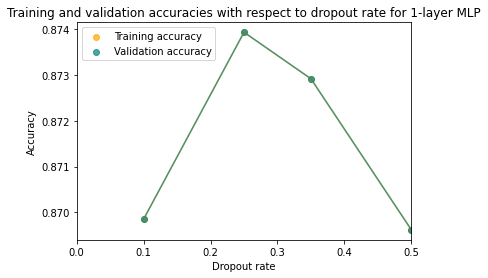

In [ ]:
# Plot train/test accuracies for each epoch
plt.plot()
plt.scatter(dropout_rates, avgValAccs5a,label='Training accuracy',c='orange',alpha=0.7)
plt.plot(dropout_rates, avgValAccs5a,'orange',alpha=0.7)
plt.scatter(dropout_rates, avgValAccs5a,label='Validation accuracy',c='teal',alpha=0.7)
plt.plot(dropout_rates, avgValAccs5a,'teal',alpha=0.7)
plt.title('Training and validation accuracies with respect to dropout rate for 1-layer MLP')
plt.xlabel('Dropout rate')
plt.ylabel('Accuracy')
plt.xlim(0, max(dropout_rates))
plt.legend()
plt.show()

We also perform hyperparameter tuning on the dropout rate for a MLP of depth 2 and width [128, 128] with ReLu activations. 

In [ ]:
dropout_rates = [.1, .25, .35, .5]
learning_rates = [.01, .1]
hyperparameters5 = [dict(activations = [ReLuAc, ReLuAc], depth = 2, widths = [128, 128], dropout_rate = d,
                        learning_rate = L, max_iters = 10000, epsilon = 1e-5, batchSize = 32
                        ) for d in dropout_rates for L in learning_rates]

# Perform hyperparameter tuning on MLP with depth 2
avgValAccs5, avgTrainAccs5, optParameter5, optValidAcc5, optTrainAcc5 = hyperparameterTuning(
    fashionMNIST,2,hyperparameters5)

print("Optimal hyperparameters: ", optParameter5)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc5)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc5)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0.1, 'learning_rate': 0.01, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.88533333 0.8848    ] 
	Valid Accuracies:  [0.86763333 0.86096667]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0.1, 'learning_rate': 0.1, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.93553333 0.924     ] 
	Valid Accuracies:  [0.8772     0.86723333]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0.25, 'learning_ra

In [ ]:
fig5 = go.Figure(data=[go.Surface(z = np.resize(avgValAccs5,(4, 2)), 
                                 x = np.array(dropout_rates), 
                                 y = np.array(learning_rates))])
fig5.update_layout(scene = dict(
                    xaxis=dict(dtick = 1, type = 'log'),
                    xaxis_title = 'Dropout rate',
                    yaxis_title = 'Learning Rate',
                    zaxis_title = 'Validation accuracy'),
                  title = 'MLP: Average 2-fold validation accuracy (ReLu, depth 2, batchSize 32)', 
                  autosize = False,
                  width = 600, 
                  height = 600)
fig5.show()

### 3.4: Unnormalized images

We now create an MLP with 2 hidden layers of width 128 with ReLu activations, but now we train it with unnormalized images. 


In [ ]:
# Hyperparameters: list of different parameter combinations
learning_rates = [.01, .1]
max_iters = [5000, 10000, 15000]
hyperparameters6 = [dict(activations = [ReLuAc, ReLuAc], depth = 2, widths = [128, 128], dropout_rate = 0,
                        learning_rate = L, max_iters = m, epsilon = 1e-5, batchSize = 32
                        ) for L in learning_rates for m in max_iters]

# Perform hyperparameter tuning on MLP with depth 2
avgValAccs6, avgTrainAccs6, optParameter6, optValidAcc6, optTrainAcc6 = hyperparameterTuning(
    unnormFashionMNIST,2,hyperparameters6)

print("Optimal hyperparameters: ", optParameter6)
print("Average validation accuracy with optimal hyperparameters: ", optValidAcc6)
print("Average training accuracy with optimal hyperparameters: ", optTrainAcc6)

Hyperparameter tuning: Round 0 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max_iters': 5000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.86483333 0.8598    ] 
	Valid Accuracies:  [0.85536667 0.8417    ]
Hyperparameter tuning: Round 1 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.01, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.8931     0.87526667] 
	Valid Accuracies:  [0.8727     0.85183333]
Hyperparameter tuning: Round 2 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



	Train Accuracies:  [0.10096667 0.09903333] 
	Valid Accuracies:  [0.09903333 0.10096667]
Hyperparameter tuning: Round 4 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.1, 'max_iters': 10000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.09976667 0.10023333] 
	Valid Accuracies:  [0.10023333 0.09976667]
Hyperparameter tuning: Round 5 
	Hyperparameter: {'activations': [<__main__.activation object at 0x7fc3e5bb4bd0>, <__main__.activation object at 0x7fc3e5bb4bd0>], 'depth': 2, 'widths': [128, 128], 'dropout_rate': 0, 'learning_rate': 0.1, 'max_iters': 15000, 'epsilon': 1e-05, 'batchSize': 32}
	Train Accuracies:  [0.0996 0.1004] 
	Valid Accuracies:  [0.1004 0.0996]
Optimal hyperparameters:  {'activations': [<__main__.activation object at 0x7fc3e5aa6650>, <__main__.activation object at 0x7fc3e5aa6650>], 'depth': 2, 'widths': [

In [ ]:
fig6 = go.Figure(data=[go.Surface(z = np.resize(avgValAccs6,(2, 3)), 
                                 x = np.array(learning_rates), 
                                 y = np.array(max_iters))])
fig6.update_layout(scene = dict(
                    xaxis=dict(dtick = 1, type = 'log'),
                    xaxis_title = 'Learning rate',
                    yaxis_title = 'Maximum number of iterations',
                    zaxis_title = 'Validation accuracy'),
                  title = 'MLP: Average 2-fold validation accuracy (unnormalized, ReLu, depth 2, batchSize 32)', 
                  autosize = False,
                  width = 600, 
                  height = 600)
fig6.show()

### 3.5: Optimal MLP architecture

After trying out various parameter, we select the MLP model with the highest test accuracy. We then compare the accuracies of the CNN model with this optimal MLP model.

In [ ]:
class GradientDescentBis:
  def __init__(self, learning_rate=.001, max_iters=1e5, epsilon=1e-5, batchSize=32):
    self.learning_rate = learning_rate
    self.max_iters = max_iters
    self.epsilon = epsilon
    self.batchSize = batchSize
        
  def run(self, gradient_fn, x, y, activations, weights, biases, depth):
    # Train/test accuracies for each epoch
    trainAccs = []
    testAccs = []

    # Separate data into mini batches
    batches = mini_batches(x,y,self.batchSize)
    norms = np.array([np.inf])
    t = 0
    batchIdx = 0

    # While gradient norms are non-null, and iterations left
    while np.any(norms > self.epsilon) and t < self.max_iters:

      # If we have used all batches, save accuracies and make new random batches
      if (batchIdx >= len(batches)): 
        # Save training accuracy for the past epoch
        trainPred = np.zeros((trainData.shape[0], trainLabels.shape[1])) 
        for n in range(trainData.shape[0]):
            _, Ztrain = feed_forward(trainData[n], activations, weights, biases, depth)
            trainPred[n] = Ztrain[-1]
        trainAccs.append(evaluate_acc(trainLabels, trainPred))

        # Save testing accuracy for the past epoch
        testPred = np.zeros((testData.shape[0], testLabels.shape[1])) 
        for n in range(testData.shape[0]):
            _, Ztest = feed_forward(testData[n], activations, weights, biases, depth)
            testPred[n] = Ztest[-1]
        testAccs.append(evaluate_acc(testLabels, testPred))

        # Make new random batches: 
        batches = mini_batches(x,y,self.batchSize)
        batchIdx = 0

      # Find weight/bias gradient on the batch
      (X_batch, Y_batch) = batches[batchIdx]
      weightGrad, biasGrad = gradient_fn(X_batch, Y_batch, activations, weights, biases)

      # Apply gradient descent on weights and biases
      for k in range(len(weights)):
        weights[k] -= self.learning_rate * weightGrad[k] 
        biases[k] -= self.learning_rate * biasGrad[k] 
      t += 1
      batchIdx += 1
      norms = np.array([np.linalg.norm(g) for g in (weightGrad+biasGrad)])

    return weights, biases, trainAccs, testAccs

In [ ]:
# Select best hyperparameters with highest validation accuracy: Relu, depth 1
bestValAccs = [optValidAcc0, optValidAcc1, optValidAcc2, optValidAcc3, optValidAcc4, optValidAcc5, optValidAcc6]
bestParams = [optParameter0, optParameter1, optParameter2, optParameter3, optParameter4, optParameter5, optParameter6]
optIdx = np.argmax(bestValAccs)
optValAcc = bestValAccs[optIdx]
optParameter = bestParams[optIdx]

# Train model with best hyperparameters and whole training set
hypMLP = {k : optParameter[k] for k in optParameter if k in paramMLP}
hypGD = dict(
    learning_rate = optParameter['learning_rate'],
    max_iters = 20000,
    epsilon = optParameter['epsilon'],
    batchSize = optParameter['batchSize'],
)
optMLP = MLP(**hypMLP)
optGD = GradientDescentBis(**hypGD)
trainAccsEpochs, testAccsEpochs = optMLP.fit(trainData, trainLabels, optGD)  

AttributeError: ignored

In [ ]:
print("Optimal MLP model:\n\tHyperparameters:", optParameter, 
      "\nTraining Accuracies:", trainAccsEpochs,
      "\nTesting Accuracies:", testAccsEpochs)

Optimal MLP model:
	Hyperparameters: {'activations': [<__main__.activation object at 0x7fc3e5bb4dd0>, <__main__.activation object at 0x7fc3e5bb4f50>], 'depth': 1, 'widths': [784, 128, 10], 'dropout_rate': 0, 'learning_rate': 0.1, 'max_iters': 15000, 'epsilon': 1e-05, 'batchSize': 32} 
Training Accuracies: [0.8627166666666667, 0.8831, 0.9004166666666666, 0.9044166666666666, 0.9092333333333333, 0.9144333333333333, 0.91855, 0.9014333333333333, 0.9201833333333334, 0.9337333333333333] 
Testing Accuracies: [0.8432, 0.8553, 0.8746, 0.8717, 0.8713, 0.8746, 0.8705, 0.8546, 0.8766, 0.884]


We plot the optimal MLP's training and testing accuracy as a function of the training epoch below. Note that one epoch corresponds to one forward/backward pass of the whole training set through the network. 


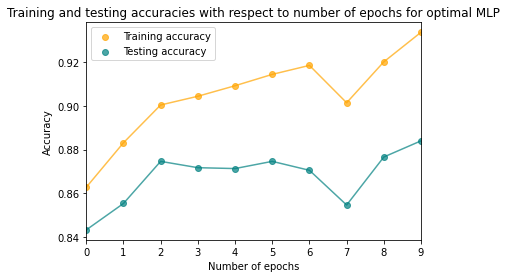

In [ ]:
# Plot train/test accuracies for each epoch
epochsMLP = list(range(len(trainAccsEpochs)))
plt.plot()
plt.scatter(epochsMLP, trainAccsEpochs,label='Training accuracy',c='orange',alpha=0.7)
plt.plot(epochsMLP, trainAccsEpochs,'orange',alpha=0.7)
plt.scatter(epochsMLP, testAccsEpochs,label='Testing accuracy',c='teal',alpha=0.7)
plt.plot(epochsMLP, testAccsEpochs,'teal',alpha=0.7)
plt.title('Training and testing accuracies with respect to number of epochs for optimal MLP')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xlim(0, max(epochsMLP))
plt.legend()
plt.show()

### 3.6: CNN



In [ ]:
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
trainY = tf.keras.utils.to_categorical(trainY)
testY = tf.keras.utils.to_categorical(testY)

# Calculate training set average and standard deviation
trainXAvg = trainX.mean(axis=0)
trainXsd = trainX.std(axis=0)

# Normalize by setting mean 0 and std 1
trainX = (trainX - trainXAvg)/trainXsd
testX = (testX - trainXAvg)/trainXsd

In [ ]:
def buildCNN():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model


Epoch 1/20
1875/1875 [==============================] - 98s 52ms/step - loss: 0.3629 - accuracy: 0.8701 - val_loss: 0.3177 - val_accuracy: 0.8868
Epoch 2/20
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2258 - accuracy: 0.9169 - val_loss: 0.2398 - val_accuracy: 0.9159
Epoch 3/20
1875/1875 [==============================] - 102s 54ms/step - loss: 0.1691 - accuracy: 0.9378 - val_loss: 0.2389 - val_accuracy: 0.9174
Epoch 4/20
1875/1875 [==============================] - 100s 53ms/step - loss: 0.1324 - accuracy: 0.9500 - val_loss: 0.2501 - val_accuracy: 0.9189
Epoch 5/20
1875/1875 [==============================] - 98s 52ms/step - loss: 0.0994 - accuracy: 0.9633 - val_loss: 0.2873 - val_accuracy: 0.9174
Epoch 6/20
1875/1875 [==============================] - 96s 51ms/step - loss: 0.0759 - accuracy: 0.9717 - val_loss: 0.2938 - val_accuracy: 0.9158
Epoch 7/20
1875/1875 [==============================] - 98s 52ms/step - loss: 0.0596 - accuracy: 0.9784 - val_loss: 0.3269

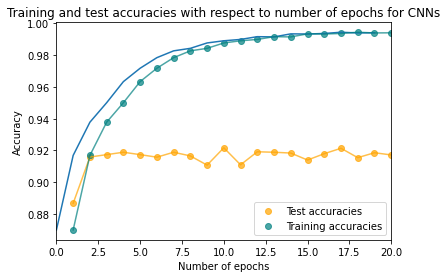

In [ ]:
# Run CNN model, gather training/test accuracies for each epoch
model = buildCNN()
history = model.fit(trainX, trainY, epochs = 20, 
                    validation_data=(testX, testY))

epochsCNN = list(range(1,21))
plt.plot(history.history['accuracy'])
# Plot test/validation accuracies
plt.plot()
plt.scatter(epochsCNN, history.history['val_accuracy'],label='Test accuracies',c='orange',alpha=0.7)
plt.plot(epochsCNN, history.history['val_accuracy'],'orange',alpha=0.7)
plt.scatter(epochsCNN, history.history['accuracy'],label='Training accuracies',c='teal',alpha=0.7)
plt.plot(epochsCNN, history.history['accuracy'],'teal',alpha=0.7)
plt.title('Training and test accuracies with respect to number of epochs for CNNs')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xlim(0, max(epochsCNN))
plt.legend()
plt.show()